<div style="text-align: center; font-size: 30pt; font-weight: bold; margin: 1em 0em 1em 0em">Homework 1</div>

$\textbf{Authors}$ : Antoine Chehire, Philippe Ware, Adel Nabli

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cloudpickle as pickle
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from time import time
from tqdm import tqdm

L:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Load the data in the format of a design matrix for X
# and one-hot encode Y

data_path = r'D:\ECP\DD\DD Canada\udm\Cours\Hivers 2019\Representation learning\DM\mnist.pkl'

with open(data_path, 'rb') as f:
    (x_train, y_train), (x_val, y_val), (x_test, y_test) = pickle.load(f, encoding='latin-1')

X_train = np.reshape(x_train, (len(x_train), 784))
X_val = np.reshape(x_val, (len(x_val), 784))
X_test = np.reshape(x_test, (len(x_test), 784))
Y_train = OneHotEncoder().fit_transform(np.reshape(y_train, (len(y_train),1))).toarray()
Y_test = OneHotEncoder().fit_transform(np.reshape(y_test, (len(y_test),1))).toarray()
Y_val = OneHotEncoder().fit_transform(np.reshape(y_val, (len(y_val),1))).toarray()

# Problem 1:

We want to build a MLP with two hidden layers with $h^1$ and $h^2$ hidden units. The data is given in the form of a design matrix $X \in \mathbb{R}^{n \times 784}$ and $\forall i \in [\![1,n]\!], y^i \in \mathbb{R}^{10}$ is the one-hot encoding of the label.
The output layer is parametrized by a $softmax$ function $s(z)_c = \dfrac{e^{z_c}}{\sum_c e^{z_c}}$.

* We choose the sigmoid function as a non linearity for both layers.
We have: $\sigma(z) = \dfrac{1}{1+ e^{-z}}$ and $\sigma'(z) = (1-\sigma(z))\sigma(z)$.


* Thus, our NN is computing, for each example $x \in \mathbb{R}^{784}$:

    - $A_1 = \sigma(W_1 x + b_1)$ with $W_1 \in \mathbb{R}^{h_1 \times 784}$ and $b_1 \in \mathbb{R}^{h_1}$
    - $A_2 = \sigma(W_2 A_1 + b_2)$ with $W_2 \in \mathbb{R}^{h_2 \times h_1}$ and $b_2 \in \mathbb{R}^{h_2}$
    - $O = s(W_3 A_2 + b_3)$ with $W_3 \in \mathbb{R}^{10 \times h_2}$ and $b_3 \in \mathbb{R}^{10}$


* The cross entropy loss is defined by: $l(y, O) = -\sum_{c=1}^{10} y_c\log(o_c)$ (recall that $y_c = \mathbb{1}_{label=c}$) which leads to a regularized empirical risk $\hat{R} = \dfrac{-1}{n} \sum_{i=1}^n \sum_{c=1}^{10} y_c^i\log(o_c^i) + \lambda \sum_{j=1}^3 ||W_j||_2^2$ if we consider an $L^2$ regularization.


* Our purpose is to learn each parameter $\theta \in \{ W_1, b_1, W_2, b_2, W_3, b_3 \}$ by **mini batch** gradient descent incrementaly: $\theta^{t+1} = \theta^t - \alpha_t \big( \dfrac{1}{|I_t|} \sum_{i_t \in I_t}\dfrac{\partial l}{\partial \theta}(x_{i_t}, y_{i_t}) + 2\lambda \theta^t \big)$  with $\alpha_t, I_t, x_{I_t}, y_{I_t}$ being respectively the learning rate, the mini-batch, the training examples and the corresponding labels at time $t$. We use the formula $\alpha_t = \dfrac{\alpha_0}{1 + \delta t}$ for the learning rate.


* For that, using the chain-rule, we derive:

    - $\dfrac{\partial l}{\partial b_3} = O - y$
    - $\dfrac{\partial l}{\partial W_3} = (O - y)A_2^{T}$
    - $\dfrac{\partial l}{\partial b_2} = \dfrac{\partial l}{\partial A_2}*(1-A_2)*A_2$ with $\dfrac{\partial l}{\partial A_2} = W_3 ^T  \dfrac{\partial l}{\partial b_3}$
    - $\dfrac{\partial l}{\partial W_2} = \dfrac{\partial l}{\partial b_2 } A_1 ^T$
    - $\dfrac{\partial l}{\partial b_1} = \dfrac{\partial l}{\partial A_1}*(1-A_1)*A_1$ with $\dfrac{\partial l}{\partial A_1} = W_2 ^T  \dfrac{\partial l}{\partial b_2}$
    - $\dfrac{\partial l}{\partial W_1} = \dfrac{\partial l}{\partial b_1 } x ^T$


* To initialize our parameters, we have three options:
    - **Zero**: we initialize with zeros
    - **Normal**: we initialize with $\mathcal{N}(0,1)$
    - **Glorot**: we initialize with $\mathcal{U}(-d^l, d^l)$ where $d^l = \sqrt{\dfrac{6}{h^{l-1}+h^l}}$

In [52]:
class NN(object):
    
    def __init__(self, hidden_dims=(1024,2048), initialization='glorot',
                 learning_rate=0.001, delta=0.7, mini_batch=32, regularization=0.001):
        
        dims = (784, hidden_dims[0], hidden_dims[1], 10)
        W1, b1, W2, b2, W3, b3 = self.initialize_weights(dims, initialization)
        parameters = dict()
        parameters['W1'] = W1
        parameters['b1'] = b1
        parameters['W2'] = W2
        parameters['b2'] = b2
        parameters['W3'] = W3
        parameters['b3'] = b3
        
        cache = dict()
        cache['x'] = None
        cache['A1'] = None
        cache['A2'] = None
        cache['O'] = None
        cache['y'] = None
        
        grad = dict()
        grad['W1'] = None
        grad['b1'] = None
        grad['W2'] = None
        grad['b2'] = None
        grad['W3'] = None
        grad['b3'] = None
        
        self.parameters = parameters
        self.cache = cache
        self.grad = grad
        self.learning_rate = learning_rate
        self.delta = delta
        self.mini_batch = mini_batch
        self.lambda_ = regularization
        self.cpt = 0
        self.n_samples = 0
        
    def initialize_weights(self,dims, initialization):
        
        # dims = (dim_input, h1, h2, dim_output)
        
        np.random.seed(42)
        
        d, h1, h2, o = dims
        b1 = np.zeros(h1)
        b2 = np.zeros(h2)
        b3 = np.zeros(o)
        
        if initialization == 'zero':
            
            W1 = np.zeros((h1, d))
            W2 = np.zeros((h2,h1))
            W3 = np.zeros((o,h2))
        
        elif initialization == 'normal':
            
            W1 = np.random.normal(0,1,(h1,d))
            W2 = np.random.normal(0,1,(h2,h1))
            W3 = np.random.normal(0,1,(o,h2))
        
        elif initialization == 'glorot':
            
            d1 = np.sqrt(6/(d+h1))
            d2 = np.sqrt(6/(h1+h2))
            d3 = np.sqrt(6/(h2+o))
            
            W1 = np.random.uniform(-d1,d1, (h1,d))
            W2 = np.random.uniform(-d2,d2, (h2,h1))
            W3 = np.random.uniform(-d3,d3, (o,h2))
        
        return(W1, b1, W2, b2, W3, b3)

    def forward(self,x,y):
        
        W1 = self.parameters['W1']
        b1 = self.parameters['b1']
        W2 = self.parameters['W2']
        b2 = self.parameters['b2']
        W3 = self.parameters['W3']
        b3 = self.parameters['b3']
        
        A1 = self.activation(np.dot(W1,x)+np.reshape(b1, (len(b1),1)))
        A2 = self.activation(np.dot(W2,A1)+np.reshape(b2, (len(b2),1)))
        O = self.softmax(np.dot(W3,A2)+np.reshape(b3, (len(b3),1)))
        
        self.cache['x'] = x
        self.cache['A1'] = A1
        self.cache['A2'] = A2
        self.cache['O'] = O
        self.cache['y'] = y

    def activation(self,U):
        
        return(1/(1+np.exp(-U)))

    def loss(self, O, y_true):
        
        W3 = self.parameters['W3']
        W2 = self.parameters['W2']
        W1 = self.parameters['W1']
        
        return(-np.mean(np.log(np.sum(O*y_true, axis=0))) + self.lambda_*(np.sum(W3**2)+np.sum(W1**2)+np.sum(W2**2)))
        
    def softmax(self,U):
        
        return(np.exp(U - np.log(np.sum(np.exp(U), axis=0))))

    def backward(self):
        
        x = self.cache['x']
        A1 = self.cache['A1']
        A2 = self.cache['A2']
        O = self.cache['O']
        y = self.cache['y']
        W3 = self.parameters['W3']
        W2 = self.parameters['W2']
        W1 = self.parameters['W1']
        n_batch = self.n_samples
        
        db3 = O-y
        self.grad['b3'] = np.mean(db3, axis=1)
        self.grad['W3'] = np.dot(db3, A2.T)*(1/n_batch) + 2*self.lambda_*W3
        dA2 = np.dot(W3.T,db3)
        db2 = dA2*(1-A2)*A2
        self.grad['b2'] = np.mean(db2, axis=1)
        self.grad['W2'] = np.dot(db2, A1.T)*(1/n_batch) + 2*self.lambda_*W2
        dA1 = np.dot(W2.T,db2)
        db1 = dA1*(1-A1)*A1
        self.grad['b1'] = np.mean(db1, axis=1)
        self.grad['W1'] = np.dot(db1, x.T)*(1/n_batch) + 2*self.lambda_*W1

    def update(self):
        
        alpha_0 = self.learning_rate
        delta = self.delta
        self.cpt += 1
        
        alpha = alpha_0/(1+delta*self.cpt)
        
        self.parameters['W1'] -= alpha*self.grad['W1']
        self.parameters['b1'] -= alpha*self.grad['b1']
        self.parameters['W2'] -= alpha*self.grad['W2']
        self.parameters['b2'] -= alpha*self.grad['b2']
        self.parameters['W3'] -= alpha*self.grad['W3']
        self.parameters['b3'] -= alpha*self.grad['b3']

    def train(self, X_train, Y_train, X_val, Y_val, n_epoch):
        
        n = len(X_train)
        n_batch = n//self.mini_batch
        ids = np.arange(n)
        averaged_loss_train = []
        averaged_loss_val = []
        accuracy_train = []
        accuracy_val = []
        
        for epoch in range(n_epoch):
            
            t0 = time()
            
            print('Epoch : %s' %epoch, '\n')
            
            np.random.shuffle(ids)
            
            for i in tqdm(range(n_batch+1)):
                
                if i == n_batch and n%self.mini_batch > 0:
                    
                    self.n_samples = n%self.mini_batch
                    x = X_train[ids[i*self.mini_batch:],:].T
                    y = Y_train[ids[i*self.mini_batch:],:].T
                
                elif i < n_batch:
                    
                    self.n_samples = self.mini_batch
                    x = X_train[ids[i*self.mini_batch:(i+1)*self.mini_batch],:].T
                    y = Y_train[ids[i*self.mini_batch:(i+1)*self.mini_batch],:].T
                
                self.forward(x,y)
                self.backward()
                self.update()
            
            Y_predict_train = self.predict(X_train.T)
            averaged_loss_train.append(self.loss(Y_predict_train, Y_train.T))
            Y_predict_val = self.predict(X_val.T)
            averaged_loss_val.append(self.loss(Y_predict_val, Y_val.T))
            
            Y_predict_train = self.predict(X_train.T)
            y_predict_train = np.argmax(Y_predict_train, axis=0)
            y_true_train = np.where(Y_train==1)[1]
            y_predict_val = np.argmax(Y_predict_val, axis=0)
            y_true_val = np.where(Y_val==1)[1]
            accuracy_train.append(accuracy_score(y_true_train, y_predict_train))
            accuracy_val.append(accuracy_score(y_true_val, y_predict_val))
            print('Accuracy val: ', accuracy_score(y_true_val, y_predict_val), '\n')
            
            t1 = time() - t0
            print('Training loss = %s' %averaged_loss_train[-1], '\n')
            print('Time taken = %s' %t1, ' seconds' '\n')
            print('========================', '\n')
        
        fig = plt.figure(figsize=(16,8))
        ax1 = fig.add_subplot(221)
        ax1.plot(np.arange(n_epoch), averaged_loss_train, label='training loss')
        ax1.plot(np.arange(n_epoch), averaged_loss_val, label='Validation loss')
        ax1.set_title('Evolution of the averaged loss during training')
        ax1.legend()
        ax2 = fig.add_subplot(222)
        ax2.plot(np.arange(n_epoch), accuracy_train, label='accuracy train')
        ax2.plot(np.arange(n_epoch), accuracy_val, label='accuracy val')
        ax2.legend()
        ax2.set_title('Evolution of the accuracy during the training')
        
        plt.show()
    
    def predict(self, x):
        
        W1 = self.parameters['W1']
        b1 = self.parameters['b1']
        W2 = self.parameters['W2']
        b2 = self.parameters['b2']
        W3 = self.parameters['W3']
        b3 = self.parameters['b3']
        
        A1 = self.activation(np.dot(W1,x)+np.reshape(b1, (len(b1),1)))
        A2 = self.activation(np.dot(W2,A1)+np.reshape(b2, (len(b2),1)))
        O = self.softmax(np.dot(W3,A2)+np.reshape(b3, (len(b3),1)))
        
        return(O)
    
    def finite_difference(self, x, y):
        
        epsilons = [1e-2, 5e-3, 1e-3, 1e-4, 1e-5]
        
        W1 = self.parameters['W1']
        b1 = self.parameters['b1']
        W2 = self.parameters['W2']
        b2 = self.parameters['b2']
        W3 = self.parameters['W3']
        b3 = self.parameters['b3']
        
        A1 = self.activation(np.dot(W1,x)+b1)
        A2 = self.activation(np.dot(W2,A1)+b2)
        O = self.softmax(np.dot(W3,A2)+b3)
        
        db3 = O-y
        grad_W3 = np.dot(np.reshape(db3, (len(db3),1)), np.reshape(A2, (1, len(A2))))
        dA2 = np.dot(W3.T,db3)
        db2 = dA2*(1-A2)*A2
        grad_W2 = np.dot(np.reshape(db2, (len(db2),1)), np.reshape(A1, (1, len(A1))))
        
        max_diff = []
        
        for epsilon in epsilons:
            
            diff = []
            
            for k in range(10):
            
                W2_plus = W2.copy()
                W2_minus = W2.copy()
            
                W2_plus[0,k] += epsilon
                W2_minus[0,k] -= epsilon

                A2_plus = self.activation(np.dot(W2_plus,A1)+b2)
                O_plus = self.softmax(np.dot(W3,A2_plus)+b3)
                loss_plus = -np.log(np.dot(O_plus,y)) + self.lambda_*(np.sum(W3**2)+np.sum(W1**2)+np.sum(W2_plus**2))

                A2_minus = self.activation(np.dot(W2_minus,A1)+b2)
                O_minus = self.softmax(np.dot(W3,A2_minus)+b3)
                loss_minus = -np.log(np.dot(O_minus,y)) + self.lambda_*(np.sum(W3**2)+np.sum(W1**2)+np.sum(W2_minus**2))
        
                estimated_grad = (loss_plus-loss_minus)/(2*epsilon)
                diff.append(np.abs(grad_W2[0,k]-estimated_grad))
        
            max_diff.append(max(diff))
        
        plt.figure(figsize=(8,8))
        plt.plot(1/np.array(epsilons), max_diff)
        plt.xscale('log')
        plt.suptitle('Evolution of the maximum of the difference between true and approximated gradient', va='bottom')
        plt.show()

## Initialization:

### Glorot:

Epoch : 0 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:27<00:00, 56.23it/s]


Accuracy val:  0.9239 

Training loss = 0 

Time taken = 33.25927019119263  seconds


Epoch : 1 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:29<00:00, 52.58it/s]


Accuracy val:  0.9386 

Training loss = 0 

Time taken = 36.01887583732605  seconds


Epoch : 2 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:30<00:00, 52.04it/s]


Accuracy val:  0.9544 

Training loss = 0 

Time taken = 36.202500104904175  seconds


Epoch : 3 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 53.01it/s]


Accuracy val:  0.9623 

Training loss = 0 

Time taken = 34.089762687683105  seconds


Epoch : 4 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:27<00:00, 56.09it/s]


Accuracy val:  0.963 

Training loss = 0 

Time taken = 33.0717077255249  seconds


Epoch : 5 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:26<00:00, 58.57it/s]


Accuracy val:  0.966 

Training loss = 0 

Time taken = 32.0487277507782  seconds


Epoch : 6 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:26<00:00, 58.10it/s]


Accuracy val:  0.9668 

Training loss = 0 

Time taken = 32.256447315216064  seconds


Epoch : 7 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:27<00:00, 56.48it/s]


Accuracy val:  0.9689 

Training loss = 0 

Time taken = 33.22788453102112  seconds


Epoch : 8 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:26<00:00, 58.24it/s]


Accuracy val:  0.9702 

Training loss = 0 

Time taken = 32.23391628265381  seconds


Epoch : 9 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:26<00:00, 59.53it/s]


Accuracy val:  0.9677 

Training loss = 0 

Time taken = 31.52009129524231  seconds




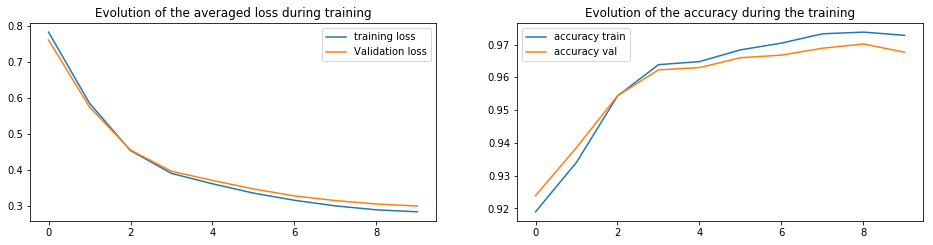

In [25]:
MLP = NN(hidden_dims=(400,700), initialization='glorot', learning_rate=4, delta=2e-3, mini_batch=32, regularization=0.0001)
MLP.train(X_train, Y_train, X_val, Y_val, 10)

### Zeros:

Epoch : 0 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:26<00:00, 59.95it/s]


Accuracy val:  0.0967 

Training loss = 0 

Time taken = 31.40697431564331  seconds


Epoch : 1 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:26<00:00, 59.35it/s]


Accuracy val:  0.2517 

Training loss = 0 

Time taken = 31.87410020828247  seconds


Epoch : 2 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:26<00:00, 58.51it/s]


Accuracy val:  0.2699 

Training loss = 0 

Time taken = 32.19155240058899  seconds


Epoch : 3 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:27<00:00, 57.53it/s]


Accuracy val:  0.2886 

Training loss = 0 

Time taken = 32.79192519187927  seconds


Epoch : 4 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:26<00:00, 58.58it/s]


Accuracy val:  0.2725 

Training loss = 0 

Time taken = 32.10981822013855  seconds


Epoch : 5 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:27<00:00, 57.67it/s]


Accuracy val:  0.292 

Training loss = 0 

Time taken = 33.315786600112915  seconds


Epoch : 6 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:27<00:00, 57.89it/s]


Accuracy val:  0.3312 

Training loss = 0 

Time taken = 32.51650667190552  seconds


Epoch : 7 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:26<00:00, 59.69it/s]


Accuracy val:  0.3473 

Training loss = 0 

Time taken = 31.879576683044434  seconds


Epoch : 8 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:26<00:00, 59.30it/s]


Accuracy val:  0.3598 

Training loss = 0 

Time taken = 31.69090700149536  seconds


Epoch : 9 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:26<00:00, 59.05it/s]


Accuracy val:  0.3426 

Training loss = 0 

Time taken = 31.883728504180908  seconds




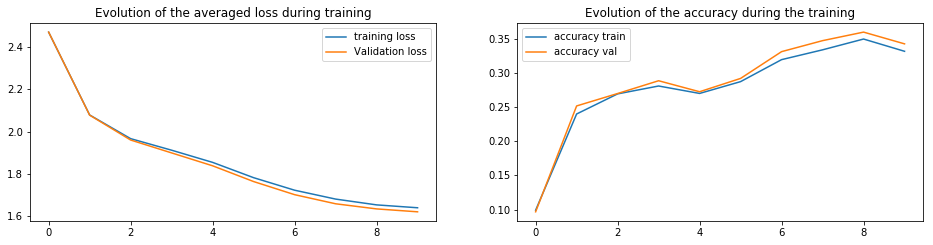

In [26]:
MLP = NN(hidden_dims=(400,700), initialization='zero', learning_rate=4, delta=2e-3, mini_batch=32, regularization=0.0001)
MLP.train(X_train, Y_train, X_val, Y_val, 10)

### Normal:

Epoch : 0 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:27<00:00, 55.96it/s]


Accuracy val:  0.925 

Training loss = 21.390625242520525 

Time taken = 33.46362495422363  seconds


Epoch : 1 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.41it/s]


Accuracy val:  0.9421 

Training loss = 13.607254551956768 

Time taken = 33.65702509880066  seconds


Epoch : 2 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:26<00:00, 58.47it/s]


Accuracy val:  0.9626 

Training loss = 10.19457707989166 

Time taken = 32.323715925216675  seconds


Epoch : 3 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:27<00:00, 57.40it/s]


Accuracy val:  0.964 

Training loss = 8.278339904837862 

Time taken = 33.11240267753601  seconds


Epoch : 4 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:29<00:00, 53.74it/s]


Accuracy val:  0.9669 

Training loss = 7.021810568941083 

Time taken = 34.927560806274414  seconds


Epoch : 5 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:27<00:00, 56.10it/s]


Accuracy val:  0.967 

Training loss = 6.134534123513527 

Time taken = 33.38402438163757  seconds


Epoch : 6 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:27<00:00, 57.11it/s]


Accuracy val:  0.9669 

Training loss = 5.466128616050095 

Time taken = 32.926153898239136  seconds


Epoch : 7 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:27<00:00, 56.76it/s]


Accuracy val:  0.9705 

Training loss = 4.940996013787525 

Time taken = 32.97569537162781  seconds


Epoch : 8 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:26<00:00, 58.27it/s]


Accuracy val:  0.9683 

Training loss = 4.524721464855893 

Time taken = 32.380871057510376  seconds


Epoch : 9 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:27<00:00, 57.10it/s]


Accuracy val:  0.9715 

Training loss = 4.175824076828247 

Time taken = 32.96682596206665  seconds




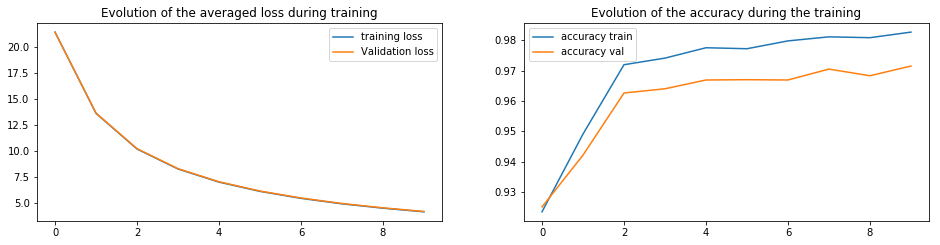

In [29]:
MLP = NN(hidden_dims=(400,700), initialization='normal', learning_rate=4, delta=2e-3, mini_batch=32, regularization=0.0001)
MLP.train(X_train, Y_train, X_val, Y_val, 10)

## Hyperparameter search:

Epoch : 0 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 54.09it/s]


Accuracy val:  0.9371 

Training loss = 0.5594703140131642 

Time taken = 34.57269024848938  seconds


Epoch : 1 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:30<00:00, 51.10it/s]


Accuracy val:  0.9494 

Training loss = 0.4563306366669434 

Time taken = 37.03916311264038  seconds


Epoch : 2 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:29<00:00, 52.31it/s]


Accuracy val:  0.9561 

Training loss = 0.38507498242354876 

Time taken = 35.84027886390686  seconds


Epoch : 3 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:29<00:00, 53.14it/s]


Accuracy val:  0.9637 

Training loss = 0.3432016099109002 

Time taken = 35.610881090164185  seconds


Epoch : 4 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 53.92it/s]


Accuracy val:  0.9652 

Training loss = 0.3252772933965116 

Time taken = 35.18803858757019  seconds


Epoch : 5 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:29<00:00, 50.74it/s]


Accuracy val:  0.9663 

Training loss = 0.3081840018006412 

Time taken = 36.08551812171936  seconds


Epoch : 6 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 57.70it/s]


Accuracy val:  0.9662 

Training loss = 0.2966887415755849 

Time taken = 34.54465961456299  seconds


Epoch : 7 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.02it/s]


Accuracy val:  0.9679 

Training loss = 0.2853963671009139 

Time taken = 34.24699831008911  seconds


Epoch : 8 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.11it/s]


Accuracy val:  0.9687 

Training loss = 0.27964126441410037 

Time taken = 34.04605555534363  seconds


Epoch : 9 



100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.13it/s]


Accuracy val:  0.9678 

Training loss = 0.27325723264913726 

Time taken = 34.04072952270508  seconds




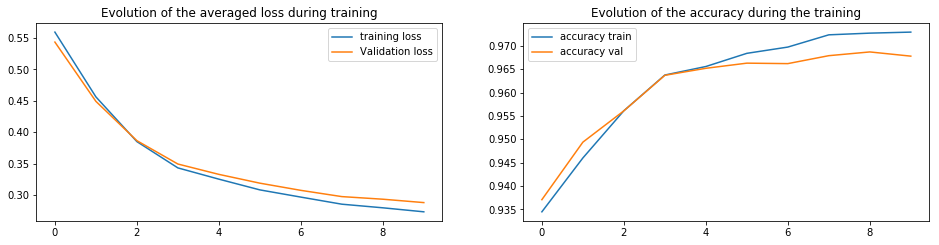

In [30]:
MLP = NN(hidden_dims=(400,700), initialization='glorot', learning_rate=3, delta=2e-3, mini_batch=32, regularization=0.0001)
MLP.train(X_train, Y_train, X_val, Y_val, 10)

Epoch : 0 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:15<00:00, 50.28it/s]


Accuracy val:  0.9243 

Training loss = 0.6697468548473557 

Time taken = 21.324926376342773  seconds


Epoch : 1 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:15<00:00, 49.54it/s]


Accuracy val:  0.8932 

Training loss = 0.6596383723467389 

Time taken = 21.510850191116333  seconds


Epoch : 2 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:15<00:00, 50.61it/s]


Accuracy val:  0.952 

Training loss = 0.4162148365064486 

Time taken = 21.279532194137573  seconds


Epoch : 3 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:15<00:00, 50.74it/s]


Accuracy val:  0.9616 

Training loss = 0.35530589330915263 

Time taken = 21.087711334228516  seconds


Epoch : 4 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:15<00:00, 50.48it/s]


Accuracy val:  0.9645 

Training loss = 0.3308390197019204 

Time taken = 21.636276483535767  seconds


Epoch : 5 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:15<00:00, 49.68it/s]


Accuracy val:  0.9662 

Training loss = 0.3119538980516731 

Time taken = 21.841534852981567  seconds


Epoch : 6 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:15<00:00, 49.99it/s]


Accuracy val:  0.9651 

Training loss = 0.29803384655766696 

Time taken = 21.67920160293579  seconds


Epoch : 7 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:15<00:00, 50.73it/s]


Accuracy val:  0.9699 

Training loss = 0.2821631963494465 

Time taken = 21.20193099975586  seconds


Epoch : 8 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:15<00:00, 49.87it/s]


Accuracy val:  0.9702 

Training loss = 0.27139173700161534 

Time taken = 21.839308738708496  seconds


Epoch : 9 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:15<00:00, 49.31it/s]


Accuracy val:  0.9661 

Training loss = 0.2724998079241634 

Time taken = 21.66120171546936  seconds




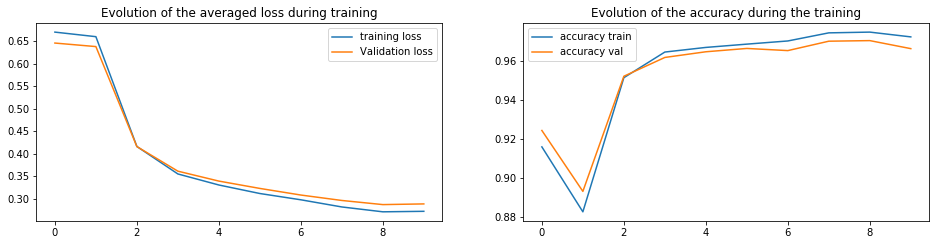

In [31]:
MLP = NN(hidden_dims=(400,700), initialization='glorot', learning_rate=4, delta=2e-3, mini_batch=64, regularization=0.0001)
MLP.train(X_train, Y_train, X_val, Y_val, 10)

Epoch : 0 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:16<00:00, 47.28it/s]


Accuracy val:  0.2292 

Training loss = 2.9722315100916683 

Time taken = 22.54770565032959  seconds


Epoch : 1 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:16<00:00, 48.11it/s]


Accuracy val:  0.2421 

Training loss = 2.630755062253223 

Time taken = 22.529380559921265  seconds


Epoch : 2 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:16<00:00, 47.14it/s]


Accuracy val:  0.2486 

Training loss = 2.5057734376935437 

Time taken = 22.84145188331604  seconds


Epoch : 3 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:16<00:00, 47.46it/s]


Accuracy val:  0.2547 

Training loss = 2.440838352282247 

Time taken = 22.2940411567688  seconds


Epoch : 4 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:15<00:00, 50.01it/s]


Accuracy val:  0.265 

Training loss = 2.400914064320009 

Time taken = 21.326958417892456  seconds


Epoch : 5 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:15<00:00, 50.67it/s]


Accuracy val:  0.2562 

Training loss = 2.37381764583316 

Time taken = 21.714455366134644  seconds


Epoch : 6 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:16<00:00, 48.50it/s]


Accuracy val:  0.2579 

Training loss = 2.3549657825422807 

Time taken = 22.069932222366333  seconds


Epoch : 7 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:16<00:00, 47.88it/s]


Accuracy val:  0.2647 

Training loss = 2.3402195097131218 

Time taken = 22.1882586479187  seconds


Epoch : 8 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:15<00:00, 49.13it/s]


Accuracy val:  0.2724 

Training loss = 2.3287647808895717 

Time taken = 22.049435138702393  seconds


Epoch : 9 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:15<00:00, 49.07it/s]


Accuracy val:  0.2642 

Training loss = 2.319417031701138 

Time taken = 22.039351224899292  seconds




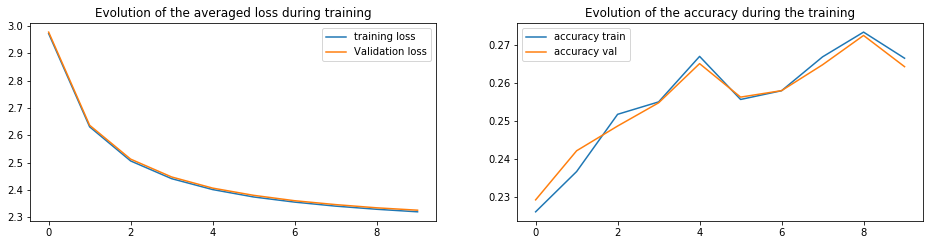

In [44]:
MLP = NN(hidden_dims=(400,700), initialization='glorot', learning_rate=4, delta=2e-1, mini_batch=64, regularization=0.01)
MLP.train(X_train, Y_train, X_val, Y_val, 10)

Epoch : 0 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:16<00:00, 48.36it/s]


Accuracy val:  0.9373 

Training loss = 0.23326586154208317 

Time taken = 22.066731214523315  seconds


Epoch : 1 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:15<00:00, 49.41it/s]


Accuracy val:  0.9235 

Training loss = 0.27234534356233003 

Time taken = 21.49147343635559  seconds


Epoch : 2 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:15<00:00, 49.35it/s]


Accuracy val:  0.9629 

Training loss = 0.11734187811709669 

Time taken = 21.770358562469482  seconds


Epoch : 3 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:15<00:00, 49.82it/s]


Accuracy val:  0.9684 

Training loss = 0.09408926432595126 

Time taken = 21.492872953414917  seconds


Epoch : 4 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:15<00:00, 49.59it/s]


Accuracy val:  0.9696 

Training loss = 0.08564704347409588 

Time taken = 21.59556007385254  seconds


Epoch : 5 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:15<00:00, 50.23it/s]


Accuracy val:  0.9709 

Training loss = 0.07648026044638939 

Time taken = 21.404848337173462  seconds


Epoch : 6 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:15<00:00, 49.13it/s]


Accuracy val:  0.9719 

Training loss = 0.07140302023953506 

Time taken = 22.01053500175476  seconds


Epoch : 7 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:16<00:00, 46.44it/s]


Accuracy val:  0.9718 

Training loss = 0.06482430253447917 

Time taken = 22.325568675994873  seconds


Epoch : 8 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:16<00:00, 47.50it/s]


Accuracy val:  0.9721 

Training loss = 0.06128841833626817 

Time taken = 22.547621965408325  seconds


Epoch : 9 



100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:16<00:00, 48.39it/s]


Accuracy val:  0.9717 

Training loss = 0.058868565425240015 

Time taken = 21.77925705909729  seconds




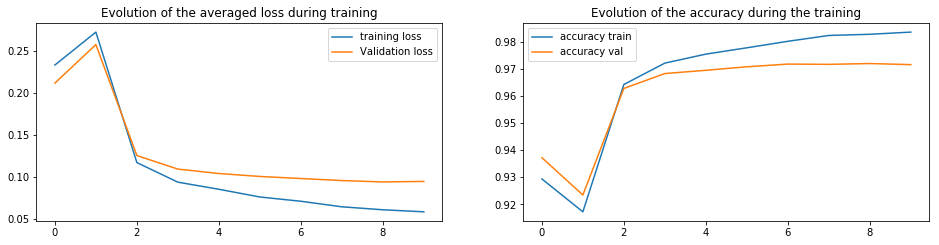

In [53]:
MLP = NN(hidden_dims=(400,700), initialization='glorot', learning_rate=4, delta=2e-3, mini_batch=64, regularization=0)
MLP.train(X_train, Y_train, X_val, Y_val, 10)

## Validate Gradients using Finite Difference:

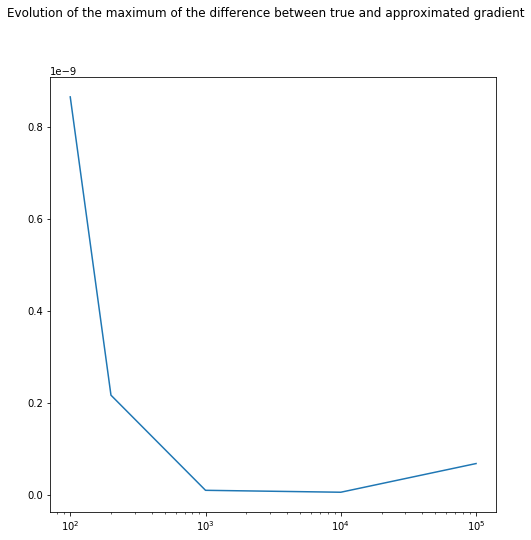

In [58]:
MLP.finite_difference(X_train[0,:], Y_train[0,:])